SST2 dataset is being used for model training in sentiment analysis, as it is suggested. The dataset ahs labels of 0 and 1 , as negative and positive respectively.

In [61]:
import torch.nn as nn



In [62]:
pip install torchdata

Note: you may need to restart the kernel to use updated packages.


In [63]:
import torchdata

In [64]:
import torchtext

In [65]:
import time
import torch

In [66]:
SEED=1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic=True

Load https://nlp.stanford.edu/sentiment/treebank.html, which is the given data

In [67]:
from torchtext.datasets import SST2

In [68]:
train_part=SST2(split='train')
test_part=SST2(split='dev')

EDA

In [69]:
list(iter(train_part))[100]


('in memory', 1)

In [70]:
set([y for x, y in list(iter(train_part))])


{0, 1}

In [71]:
train_size = len(list(iter(train_part)))
train_size

67349

In [72]:
train_part, val = train_part.random_split(total_length=train_size, 
                                            weights = {"train": 0.99, 
                                                       "val": 0.01},
                                            seed = SEED)

In [73]:
train_size = len(list(iter(train_part)))
val_size   = len(list(iter(val)))
test_size  = len(list(iter(test_part)))

In [74]:
train_size, val_size, test_size


(66675, 674, 872)

Preprocessing

In [75]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_md')


In [76]:
next(iter(train_part))


('hide new secretions from the parental units', 0)

In [77]:
## 3.2 Numericalization

from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter):  #data_iter, e.g., train
    for text,_, in data_iter:
        yield tokenizer(text)
        
vocab = build_vocab_from_iterator(yield_tokens(train_part), specials=['<unk>', '<pad>','<bos>', '<eos>'])

In [78]:
vocab.set_default_index(vocab["<unk>"])

In [79]:
vocab(['Chaky', 'wants', 'his', 'student', 'to', 'be', 'number', '1', '.'])


[0, 935, 42, 3491, 11, 27, 956, 2974, 9]

FastText embedding

In [80]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple')

In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [82]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)


In [83]:
fast_embedding.shape #(vocab size, 300) == (52k, 300)


torch.Size([13882, 300])

In [84]:
fast_embedding[100][:10]

tensor([-0.0129, -0.3870,  0.4670,  0.0256,  0.1554, -0.0399, -0.2793,  0.0717,
        -0.4365,  0.2239])

preparing dataloader

In [85]:
text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)  #1, 2, 3, 4 ---> 0, 1, 2, 3

In [86]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence #making each batch same length

pad_ix = vocab['<pad>']

#this function gonna be called by DataLoader
def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_text, _label) in batch:
        label_list.append(label_pipeline(_label))  #[3, 1, 0, 2, ]
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64) #[0, 44, 21, 2]
        text_list.append(processed_text)
        length_list.append(processed_text.size(0)) #for padding
        
    return torch.tensor(label_list, dtype=torch.int64), \
        pad_sequence(text_list, padding_value=pad_ix, batch_first=True), \
        torch.tensor(length_list, dtype=torch.int64)

In [87]:
batch_size = 64

train_loader = DataLoader(train_part, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)

val_loader   = DataLoader(val, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)

test_loader  = DataLoader(test_part, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)

In [88]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, 
                 dropout):
        super().__init__()
        #input dim = how many vocab you have
        #emb dim = 300 --> we use fasttext
        #padding_idx tells this lookup table to ignore, and just randomize....
        #<unk>, <bos>, <eos>
        self.embedding_layer = nn.Embedding(input_dim, emb_dim, padding_idx=pad_ix)
        self.lstm            = nn.LSTM(emb_dim,
                                       hid_dim,
                                       num_layers = num_layers,
                                       bidirectional = bidirectional,
                                       dropout = dropout,  #dropout is applied between layers....
                                       batch_first=True)
        
        self.fc              = nn.Linear(hid_dim * 2, output_dim)
        
    def forward(self, x, lengths):
        #x: [batch size, seq len]
        
        embedded_x = self.embedding_layer(x)
        #x: [batch size, seq len, emb dim]
        
        #pack this embedded_x in such a way that RNN knows to ignore padding....
        #without batch_first = True; things will become [seq len, batch size, emb dim]
        pack_embedded = nn.utils.rnn.pack_padded_sequence(embedded_x, lengths.to('cpu'),
                                                          enforce_sorted=False,
                                                          batch_first = True
                                                          )
        
        #packed_outputs is basically all hidden states
        #h is the last hidden state
        #c is the last cell state
        packed_outputs, (h, _) = self.lstm(pack_embedded)
        
        #h: [num_layers * num_directions, batch_size, hidden dim]
        
        #it happens that because packed_outputs is all hidden states....some hidden states near the end is
        #hidden state for padding, pytorch guys help you
        #by using this pad_packed_sequence, then all the hidden states will only be not padding....
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first = True)
        #output: [batch size, seq len, direction * hidden sim]
        
        #last hidden state - concat last forward and backward states
        last_hidden_state = torch.cat((h[-1, :, :], h[-2, :, :]), dim = 1)
        #last_hidden_state: [batch_size, hidden_dim * 2]
        
        #for sentiment analysis.....what should i sent to my linear layer...
        return self.fc(last_hidden_state)  #[batch_size, output_dim]==> [batch_size, 4]

Training the model

In [89]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [90]:
input_dim  = len(vocab)
hid_dim    = 256
emb_dim    = 300
output_dim = 2 # two classes

#for biLSTM
num_layers = 2
bidirectional = True
dropout = 0.5

model = LSTM(input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout).to(device)
model.apply(initialize_weights)
model.embedding_layer.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [91]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

4164600
307200
262144
  1024
  1024
307200
262144
  1024
  1024
524288
262144
  1024
  1024
524288
262144
  1024
  1024
  1024
     2
______
6885370


In [92]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

In [93]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [94]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text, text_length).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [95]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text, text_length).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [96]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(val_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [97]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [98]:
for label, text, length in train_loader:
    break
print("Label shape:", label.shape)
print("Text shape:", text.shape)

Label shape: torch.Size([64])
Text shape: torch.Size([64, 37])


In [99]:
best_valid_loss = float('inf')
num_epochs      = 5

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Time: 13m 27s
	Train Loss: 0.311 | Train Acc: 86.54%
	 Val. Loss: 0.154 |  Val. Acc: 95.35%
Epoch: 02 | Time: 12m 5s
	Train Loss: 0.155 | Train Acc: 94.20%
	 Val. Loss: 0.105 |  Val. Acc: 96.75%
Epoch: 03 | Time: 11m 15s
	Train Loss: 0.100 | Train Acc: 96.24%
	 Val. Loss: 0.071 |  Val. Acc: 97.32%
Epoch: 04 | Time: 11m 4s
	Train Loss: 0.074 | Train Acc: 97.19%
	 Val. Loss: 0.049 |  Val. Acc: 97.87%
Epoch: 05 | Time: 11m 14s
	Train Loss: 0.056 | Train Acc: 97.79%
	 Val. Loss: 0.027 |  Val. Acc: 99.01%


Text(0, 0.5, 'loss')

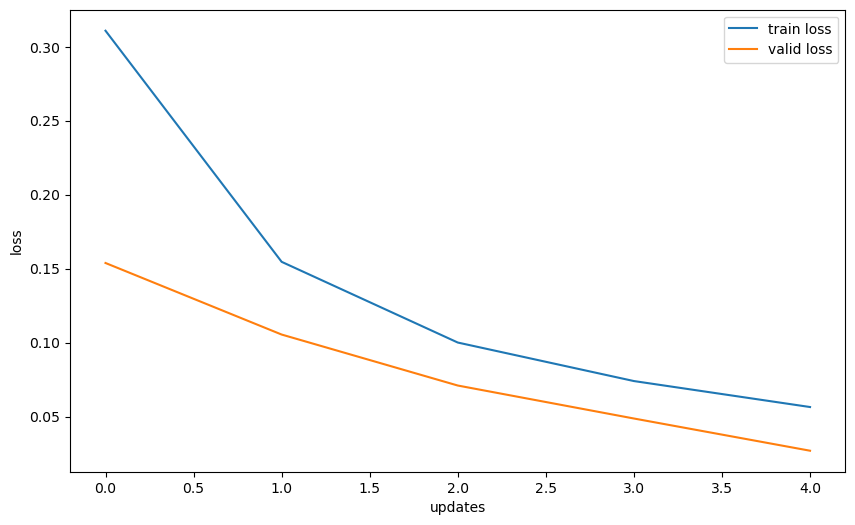

In [100]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

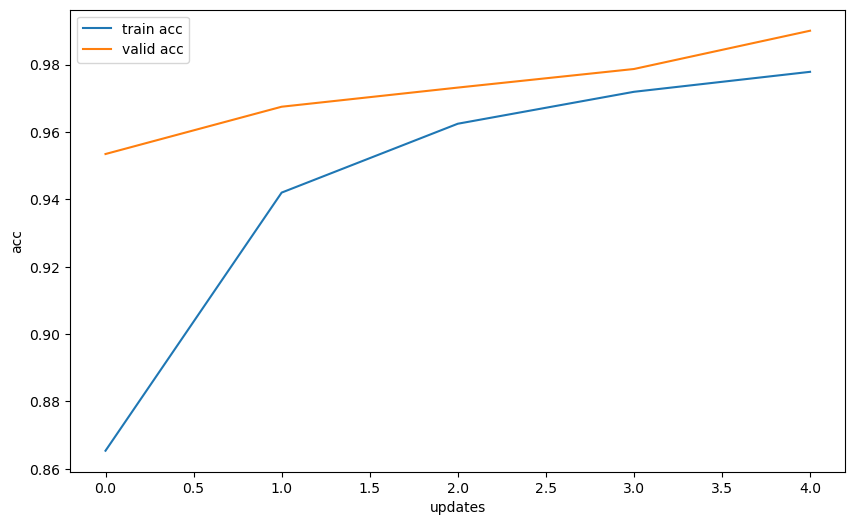

In [101]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

Test on some news

In [102]:
test_str = "Meta is now falling nonstop."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([   0,   13,  567, 4399, 4701,    9])

In [103]:
text_list = [x.item() for x in text]
text_list

[0, 13, 567, 4399, 4701, 9]

In [105]:
mapping = vocab.get_itos()

In [106]:
[mapping[num] for num in text_list]


['<unk>', 'is', 'now', 'falling', 'nonstop', '.']

In [107]:
text = text.reshape(1, -1)  #because batch_size is 1


In [108]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)


In [109]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [110]:
predict(text, text_length)


tensor([1])

Negative negative sentence

In [111]:
test_str = "Meta is doing good."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([  0,  13, 784,  50,   9])

In [112]:
text_list = [x.item() for x in text]
text_list

[0, 13, 784, 50, 9]

In [113]:
[mapping[num] for num in text_list]


['<unk>', 'is', 'doing', 'good', '.']

In [114]:
text = text.reshape(1, -1)  #because batch_size is 1


In [115]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)


In [116]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [117]:
predict(text, text_length)


tensor([1])

Negative Positive sentence

In [118]:
test_str = "Meta is not doing good."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([  0,  13,  37, 784,  50,   9])

In [119]:
text_list = [x.item() for x in text]
text_list

[0, 13, 37, 784, 50, 9]

In [120]:
[mapping[num] for num in text_list]


['<unk>', 'is', 'not', 'doing', 'good', '.']

In [121]:
text = text.reshape(1, -1)  #because batch_size is 1


In [122]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)


In [123]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [124]:
predict(text, text_length)


tensor([0])

From the model here, we can see that the model is achieveing high accuracy and is performing well.